In [175]:
import random
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

from ipywidgets import interact

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style('white')
sns.set_context('talk')

In [2]:
def genereate_conversion(x, y):
    """
    generate list of observed conversions for channel
    x :    numbere of users 
    y :    number of users that compleated conversion
    return:list of 0 and 1 integers size x 
    """
    conv_list = [0]*(x-y) + [1]*y
    random.shuffle(conv_list)
    
    return conv_list

## Generating syntetic data of conversion for 2 channels

In [3]:
channel_1 = genereate_conversion(100, 8)
channel_2 = genereate_conversion(100, 18)

In [4]:
print(channel_1[:20])
print(channel_2[:20])

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


Lets take a look which channel has better conversion by just taking mean 

In [5]:
print('Mean conversion for channel_1 : {} '.format(np.mean(channel_1)))
print('Mean conversion for channel_2 : {} '.format(np.mean(channel_2)))

Mean conversion for channel_1 : 0.08 
Mean conversion for channel_2 : 0.18 


Aperanntly channel_2 is better but we dont't know how sure is it better. We don't have any uncertainty.

## Crteate the model for channel 1

In [6]:
with pm.Model() as model_channel_1:
    
    # Parameter = prior solution space. We belive that data for conv_rate falls in B distrib-n
    conversion_rate = pm.Beta("conversion_rate_1", 
                             alpha = 2., beta = 10.)
    # Binomial Likelihood
    like = pm.Binomial(
        'likelihood', 
        n=len(channel_1), 
        p=conversion_rate, 
        observed=len([x for x in channel_1 if x ==1])
    )

### Posterior solution space

In [7]:
with model_channel_1:
    plausible_values_1 = pm.sample()

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [conversion_rate_1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 29 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Lets look at all possible values for conversion rate of channel 1

[0.07791198 0.06137685 0.05331582 ... 0.06655939 0.07879995 0.07879995]


C:\Program Files\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


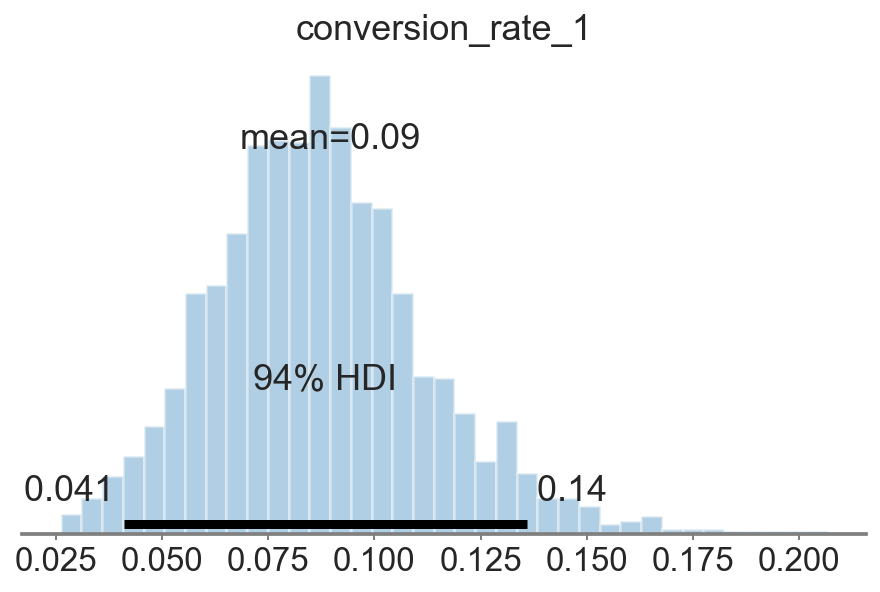

In [9]:
print(plausible_values_1['conversion_rate_1'])

# Posterior plot for bernoulli model
az.plot_posterior(plausible_values_1, kind = 'hist');

94% of credibility assigned within black bar region

### What kind of values of conversion rate from channel 1 are smaller then 0.1 ?

In [8]:
plausible_values_1['conversion_rate_1'] < 0.1

array([False, False, False, ...,  True,  True, False])

### What is the probability that the conversion rate of channel 1 is smaller then 10% ?

In [11]:
np.mean(plausible_values_1['conversion_rate_1'] < 0.1)*100

66.8

## Build Model: Compare conversion_rate for channel_1 and channel_2

Having built the model for the channel_1, let's now extend it to compare the channel_1 and channel_1.

In [12]:
with pm.Model() as model2:
    
    # Parameter = prior solution space. We belive that data for conv_rate falls in B distrib-n
    conversion_rate_1 = pm.Beta("conversion_rate_1", 
                             alpha = 2., beta = 10.)
    # Binomial Likelihood
    like_1 = pm.Binomial(
        'like_channel_1', 
        n=len(channel_1), 
        p=conversion_rate_1, 
        observed=len([x for x in channel_1 if x ==1])
    )
    
    # Modify the above p and likelihood for channel 2.
    conversion_rate_2 = pm.Beta("conversion_rate_2", 
                             alpha = 2., beta = 10.)
    # Binomial Likelihood
    like_2 = pm.Binomial(
        'like_channel_2', 
        n=len(channel_2), 
        p=conversion_rate_2, 
        observed=len([x for x in channel_2 if x ==1])
    )
    
    # We will also explicitly compute the difference between
    # p_channel_1 and p_channel_2. 
    # This shows you that we can do math on probability distributions!
    
    conv_diff = pm.Deterministic("conv_diff", conversion_rate_2 - conversion_rate_1)

In [13]:
with model2:
    plausible_values = pm.sample()

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [conversion_rate_2, conversion_rate_1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.


C:\Program Files\Anaconda\lib\site-packages\arviz\data\io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


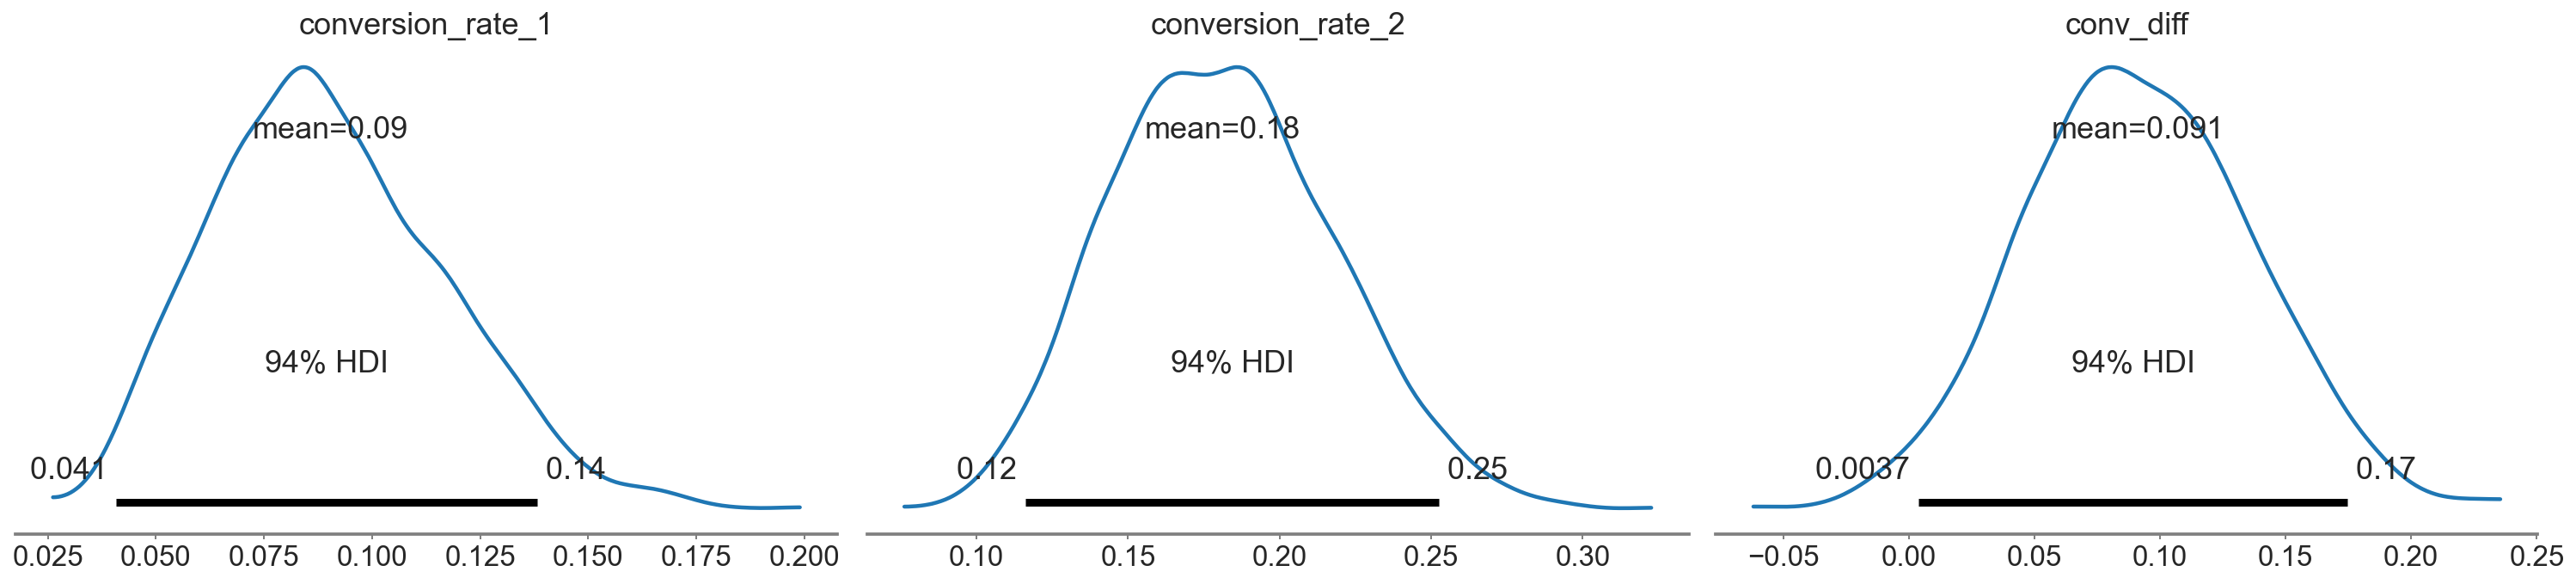

In [14]:
az.plot_posterior(plausible_values);

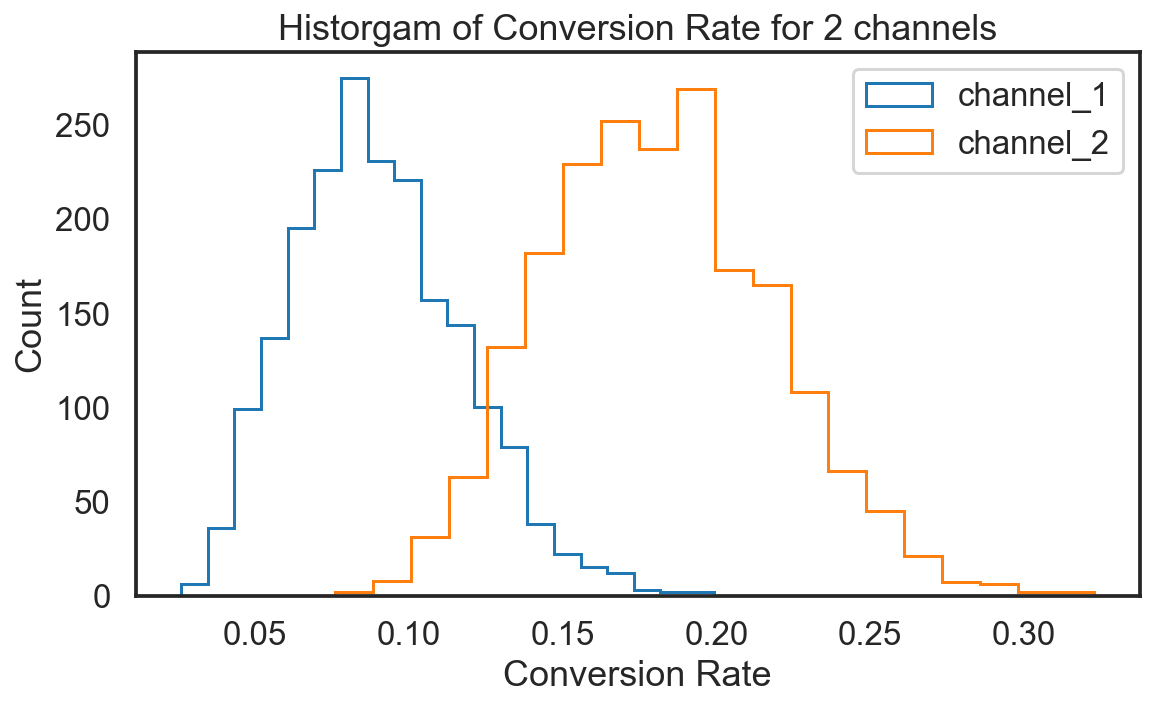

In [22]:
fig, ax = plt.subplots(figsize = (9,5))

ax.hist(plausible_values['conversion_rate_1'], label="channel_1", bins=20, histtype='step')
ax.hist(plausible_values['conversion_rate_2'], label="channel_2", bins=20, histtype='step')

ax.set_xlabel('Conversion Rate')
ax.set_ylabel('Count')
ax.set_title('Historgam of Conversion Rate for 2 channels')

ax.legend()
plt.show()

### What is the probability that the conversion rate of channel_1 better then channel_2

In [23]:
diff = plausible_values['conversion_rate_1'] > plausible_values['conversion_rate_2']

In [24]:
str(round(np.mean(diff)*100,2))+'%'

'2.2%'

## Hierarchical model

To build a hierarchical model, we essentially need to define a prior on the parameters of the Beta distribution. These new priors now become "hyperpriors". How do we pick hyperpriors then? Some qualitative rules of thumb:

1. Pick a distribution with the correct **support**. For example, if a parameter can/should never take negative values, then pick a distribution with only positive support.
1. The distribution should be **weakly informative**. For example, rather than a uniform distribution hyperprior, one might choose a wide distribution (relative to the relevant scale of the parameters) that spans 1 order of magnitude difference, but still has uneven allocation of credibility. 

Use the PyMC3 distribution library to your advantage! There are pictures that show you the shapes of the distributions, which can be helpful in narrowing your choices.

### Generating Synthetic Data for 760 different channels

In [152]:
l = np.arange(40, 800)
random.shuffle(l)

conv_numbers = []
for n in l:
    i = np.random.randint(2,5)
    conv_number = np.random.randint(5, n/i)
    conv_numbers.append(conv_number)
    
chanels = pd.read_csv("channels.csv").playerID.iloc[0:760].values
data = pd.DataFrame(zip(l,conv_numbers,chanels), columns=['n_appearance','n_conversion','channel_name'])
data = data.set_index('channel_name')
data['channel_id_enc'] = np.arange(0,760)

In [153]:
data.head()

,n_appearance,n_conversion,channel_id_enc
channel_name,,,
abercda01,267,17,0
addybo01,458,208,1
allisar01,615,11,2
allisdo01,291,31,3
ansonca01,373,25,4


In [170]:
with pm.Model() as hierarchical_channels:
    a_prior = pm.Exponential("a_prior", lam=2.)
    b_prior = pm.Exponential("b_prior", lam=10.)
    
    conversion = pm.Beta("conversion", alpha=a_prior, beta=b_prior, shape=(len(data)))
    
    like = pm.Binomial("like", p=conversion, n=data['n_appearance'], observed = data['n_conversion'])
    
    #pps = pm.Deterministic("pps", p / data['salary'])

In [171]:
with hierarchical_channels:
    trace_hierarchical = pm.sample(2000)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [conversion, b_prior, a_prior]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 69 seconds.


<AxesSubplot:title={'center':'x'}>

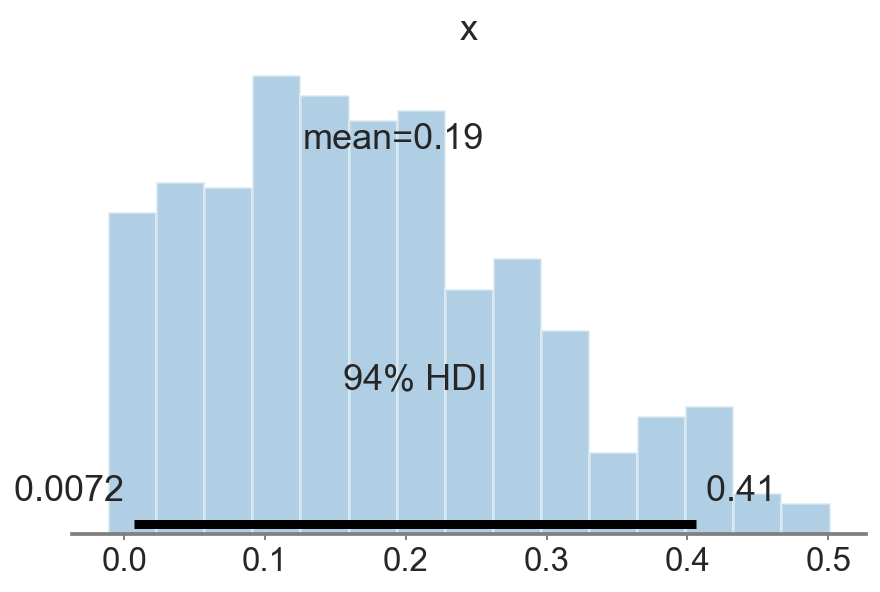

In [179]:
az.plot_posterior(trace_hierarchical['conversion'][1], kind = 'hist')

In [174]:
from ipywidgets import SelectMultiple, HBox, VBox, Select, fixed

def dict2tuple(d):
    return list(*zip(*zip(d.items())))

def inversedict(d):
    return {v:k for k, v in d.items()}

channelid_mapping = data['channel_id_enc'].to_dict()
channelid_inverse = inversedict(channelid_mapping)

channel_select = SelectMultiple(
    options=dict2tuple(channelid_mapping),
    value=(0,)
)

metric_select = Select(
    options=['channel'],
)

In [178]:
def scrub_posterior(channels_encs: list, metric: str, trace):
    fig, ax = plt.subplots()
    #for enc in player_encs:
    #    x, y = ECDF(trace[metric][:, enc])
    #    ax.plot(x, y, label=playerid_inverse[enc])
    #ax.legend()
    #ax.set_xlabel("p per salary")
    #ax.set_ylabel('cumulative probability')
        
    sns.despine()
    
    
interact(scrub_posterior, channel_encs=channel_select, metric=metric_select, trace=fixed(trace_hierarchical));

ValueError: <class 'list'> cannot be transformed to a widget